In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
import os
import scipy.ndimage as nd
import scipy.io as io
import numpy as np
import matplotlib.pyplot as plt
import skimage.measure as sk
from utils import utils
plt.style.use('ggplot')

In [3]:
from torchvision import datasets
from torchvision import transforms as tfs
from torch.utils import data
import torch
import PIL.ImageOps
import skimage
from sklearn import metrics

In [4]:
available_device = "cuda" if torch.cuda.is_available() else "cpu"

#### Load dataset

In [5]:
transformations = [
                   #tfs.RandomAffine(0., scale=(0.5, 1.), fillcolor=0),
                   tfs.Resize((224, 224)),
                   tfs.Grayscale(1),
                   tfs.Lambda(lambda x: PIL.ImageOps.invert(x))]

imagenet_data = datasets.ImageFolder('data/perfiles_CATA/png_clasificados/',
                                     transform=tfs.Compose(transformations))

data_loader = data.DataLoader(imagenet_data, batch_size=4, shuffle=False)

#### Process type of vessels for classification

In [6]:
df = utils.create_df_from_files(path='data/perfiles_CATA/clases/')

#### Build and train classifier

In [7]:
imagenet_data = datasets.ImageFolder('data/perfiles_CATA/png_clasificados/',
                                     transform=tfs.Compose([
                                                           #tfs.RandomHorizontalFlip(p=0.7),
                                                           #tfs.RandomAffine(0, scale=(0.7, 1.), fillcolor=0),
                                                           tfs.Resize((224, 224)),
                                                           tfs.Grayscale(1),
                                                           tfs.Lambda(lambda x: PIL.ImageOps.invert(x)),
                                                           tfs.ToTensor(),
                                                           tfs.Normalize((0.5,), (0.5,))
                                                           ]))



In [8]:
splits_len = round(len(imagenet_data.samples)*0.2), round(len(imagenet_data.samples)*0.1), round(len(imagenet_data.samples)*0.7)

In [9]:
splits_len = splits_len if np.sum(splits_len) == len(imagenet_data.samples) else splits_len[0]-1, splits_len[1], splits_len[2] +2

#### Random split

In [10]:
splits = utils.random_split(imagenet_data, splits_len)

In [11]:
import pickle
file_pi2 = open('data_pickle/indice_0.pickle', 'rb') 
splits[0].indices = pickle.load(file_pi2)
print(len(splits[0].indices))

file_pi2 = open('data_pickle/indice_1.pickle', 'rb') 
splits[2].indices = pickle.load(file_pi2)
print(len(splits[2].indices))

256
898


In [12]:
train_loader = data.DataLoader(splits[2], batch_size=32, shuffle=False)
test_loader = data.DataLoader(splits[0], batch_size=32, shuffle=False)

In [13]:
y_real_test, X_test = utils.iterations_test_pixel(test_loader)
y_real_train, X_train = utils.iterations_test_pixel(train_loader)

In [14]:
len(X_test), len(X_train)

(256, 898)

In [15]:
y_real_test, X_test = np.array(y_real_test), np.array(X_test).reshape(-1, 224*224)
y_real_train, X_train = np.array(y_real_train), np.array(X_train).reshape(-1, 224*224)

In [16]:
import pandas as pd
from time import time
from sklearn import manifold
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

In [17]:
files_train = np.array(imagenet_data.imgs)[train_loader.dataset.indices][:, 0]

# UMAP

<Figure size 1296x864 with 0 Axes>

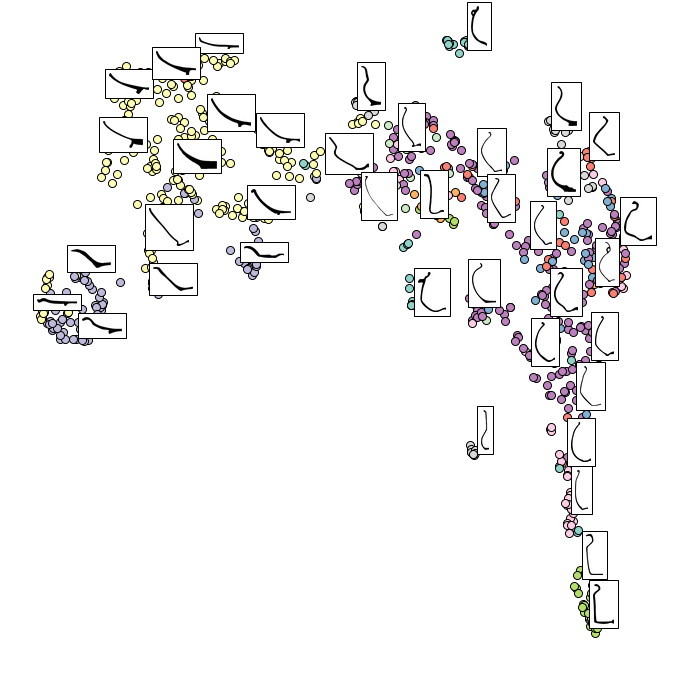

In [18]:
import umap
plt.rcParams['figure.figsize'] = [9.0*2, 6.0*2]
merged_train = pd.DataFrame(np.concatenate(( np.expand_dims(files_train, 1), np.expand_dims(y_real_train, 1)), axis=1))
fit = umap.UMAP(
        n_neighbors=15,
        min_dist=0.1,
        n_components=2,
        metric='euclidean', 
        random_state=17
    )
u = fit.fit_transform(X_train);
fig = plt.figure()
#ax = fig.add_subplot(111)
utils.plot_embedding(u[:,[0,1]], merged_train, "", 11)
#ax.scatter(u[:,0], u[:,1], c=c)
plt.gca().set_aspect('equal')
plt.savefig("result_plot/raw/unap_raw_224.png", dpi=300, bbox_inches='tight')
plt.show()

# SVM

In [19]:
from sklearn.svm import SVC
clf = SVC(gamma='auto', random_state=17)
clf.fit(X_train, y_real_train)
y_pred_test = clf.predict(X_test)

Normalized confusion matrix


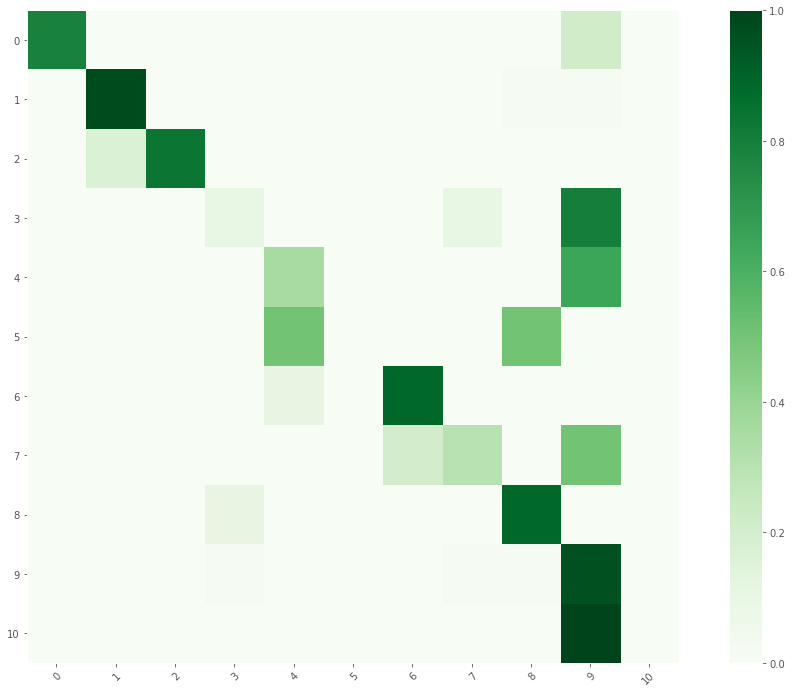

In [20]:
utils.plot_confusion_matrix(y_real_test, y_pred_test, list(range(10)), "result_plot/raw/svm_confusion_matrix_raw_224.png", normalize=True)

# RandomForestClassifier

In [21]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=500, max_depth=4, random_state=17)
clf.fit(X_train, y_real_train)
y_pred_test = clf.predict(X_test)

Normalized confusion matrix


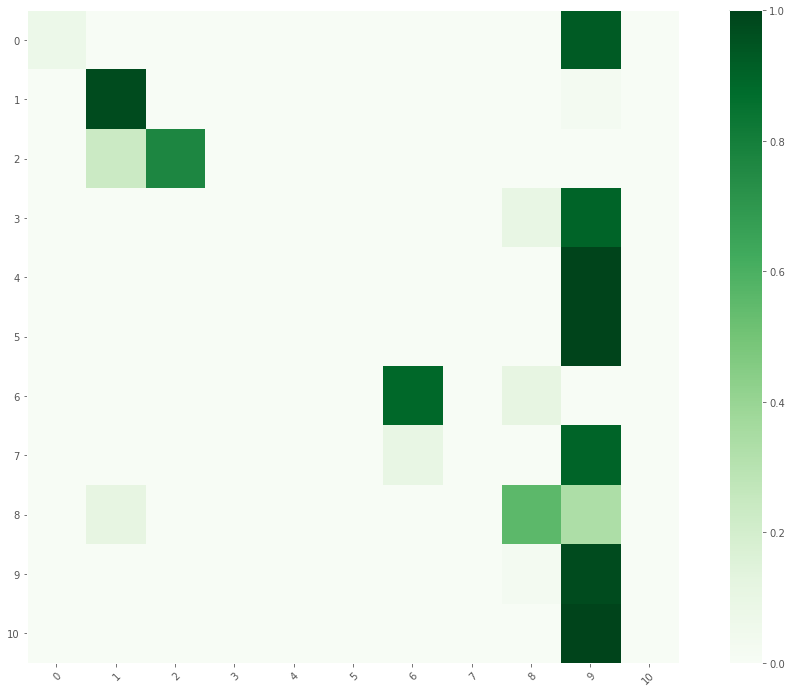

In [22]:
utils.plot_confusion_matrix(y_real_test, y_pred_test, list(range(11)), "result_plot/raw/rfc_confusion_matrix_raw_224.png", normalize=True)

In [23]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score 
from sklearn.metrics import recall_score 
from sklearn.metrics import precision_score 
from sklearn.metrics import make_scorer

In [24]:
X_train, y_real_train = np.array(X_train), np.array(y_real_train)
X_test, y_real_test = np.array(X_test), np.array(y_real_test)

In [25]:
X_train = np.concatenate((X_train, X_test))

In [26]:
y_real_train = np.concatenate((y_real_train, y_real_test))

# CROSS VAL SVC

In [27]:
precision = lambda y_true, y_pred: precision_score(y_true, y_pred, average='macro')
clf = SVC(gamma='auto')
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=17)
scores = cross_validate(clf, X_train, y_real_train, scoring=make_scorer(precision), cv=cv,return_estimator=True) 
#scores = cross_val_score(clf, X_test, y_real_test, cv=cv) 
print("Train Precision: %0.2f (+/- %0.2f)" % (scores['train_score'].mean(), scores['train_score'].std() * 2))
print("Test Precision: %0.2f (+/- %0.2f)" % (scores['test_score'].mean(), scores['test_score'].std() * 2))

Train Precision: 0.87 (+/- 0.07)
Test Precision: 0.69 (+/- 0.08)


In [28]:
f1score = lambda y_true, y_pred: f1_score(y_true, y_pred, average='macro')
clf = SVC(gamma='auto')
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=17)
scores = cross_validate(clf, X_train, y_real_train, scoring=make_scorer(f1score), cv=cv,return_estimator=True) 
#scores = cross_val_score(clf, X_test, y_real_test, cv=cv) 
print("Train F1Score: %0.2f (+/- %0.2f)" % (scores['train_score'].mean(), scores['train_score'].std() * 2))
print("Test F1Score: %0.2f (+/- %0.2f)" % (scores['test_score'].mean(), scores['test_score'].std() * 2))

Train F1Score: 0.71 (+/- 0.05)
Test F1Score: 0.60 (+/- 0.05)


In [29]:
recall = lambda y_true, y_pred: recall_score(y_true, y_pred, average='macro')
clf = SVC(gamma='auto')
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=17)
scores = cross_validate(clf, X_train, y_real_train, scoring=make_scorer(recall), cv=cv,return_estimator=True) 
#scores = cross_val_score(clf, X_test, y_real_test, cv=cv) 
print("Train Recall: %0.2f (+/- %0.2f)" % (scores['train_score'].mean(), scores['train_score'].std() * 2))
print("Test Recall: %0.2f (+/- %0.2f)" % (scores['test_score'].mean(), scores['test_score'].std() * 2))

Train Recall: 0.68 (+/- 0.03)
Test Recall: 0.59 (+/- 0.05)


# CROSS VAL RandomForestClassifier

In [30]:
clf = RandomForestClassifier(n_estimators=500,max_depth=4)
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=17)
scores = cross_validate(clf, X_train, y_real_train, scoring=make_scorer(precision), cv=cv,return_estimator=True) 
print("Train Precision: %0.2f (+/- %0.2f)" % (scores['train_score'].mean(), scores['train_score'].std() * 2))
print("Test Precision: %0.2f (+/- %0.2f)" % (scores['test_score'].mean(), scores['test_score'].std() * 2))

Train Precision: 0.61 (+/- 0.09)
Test Precision: 0.44 (+/- 0.04)


In [31]:
clf = RandomForestClassifier(n_estimators=500,max_depth=4)
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=17)
scores = cross_validate(clf, X_train, y_real_train, scoring=make_scorer(f1score), cv=cv,return_estimator=True) 
print("Train F1Score: %0.2f (+/- %0.2f)" % (scores['train_score'].mean(), scores['train_score'].std() * 2))
print("Test F1Score: %0.2f (+/- %0.2f)" % (scores['test_score'].mean(), scores['test_score'].std() * 2))

Train F1Score: 0.46 (+/- 0.02)
Test F1Score: 0.39 (+/- 0.03)


In [32]:
clf = RandomForestClassifier(n_estimators=500,max_depth=4)
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=17)
scores = cross_validate(clf, X_train, y_real_train, scoring=make_scorer(recall), cv=cv,return_estimator=True) 
print("Train Recall: %0.2f (+/- %0.2f)" % (scores['train_score'].mean(), scores['train_score'].std() * 2))
print("Test Recall: %0.2f (+/- %0.2f)" % (scores['test_score'].mean(), scores['test_score'].std() * 2))

Train Recall: 0.46 (+/- 0.03)
Test Recall: 0.41 (+/- 0.04)
